#### Code to train models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/theo/kaggle/siim_covid/src


## Imports

In [3]:
import os
import cv2
import ast
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm

In [4]:
from params import *

In [5]:
from data.preparation import prepare_dataframe, handle_duplicates, add_additional_boxes
from data.dataset import CovidDetDataset, CovidClsDataset
from data.transforms import get_transfos_det, get_transfos_cls

from model_zoo.models import get_model

from utils.plot import plot_sample
from utils.logger import prepare_log_folder, save_config, create_logger, update_overall_logs

from training.main import k_fold

## Data

### Load

In [6]:
df = prepare_dataframe().copy()

In [7]:
clusts = np.load("../output/clusts.npy", allow_pickle=True)
found = np.load("../output/found.npy")
transpositions = np.load("../output/transpositions.npy", allow_pickle=True)

df = handle_duplicates(df, clusts, transpositions, plot=False)

In [8]:
df = add_additional_boxes(df)

In [9]:
df['is_pl'] = 0
df['root'] = DATA_PATH + f"train_{SIZE}/"

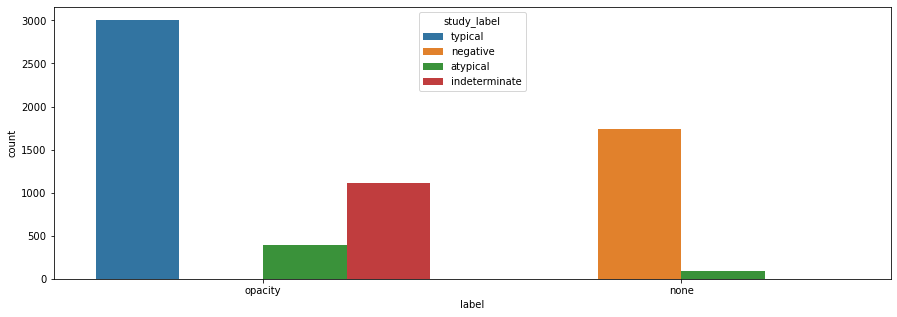

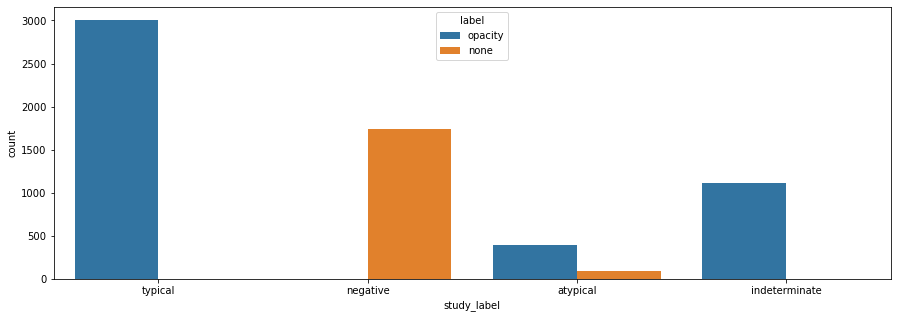

In [10]:
plt.figure(figsize=(15, 5))
sns.countplot(x="label", hue="study_label", data=df)
plt.show()

plt.figure(figsize=(15, 5))
sns.countplot(x="study_label", hue="label", data=df)
plt.show()

### Dataset

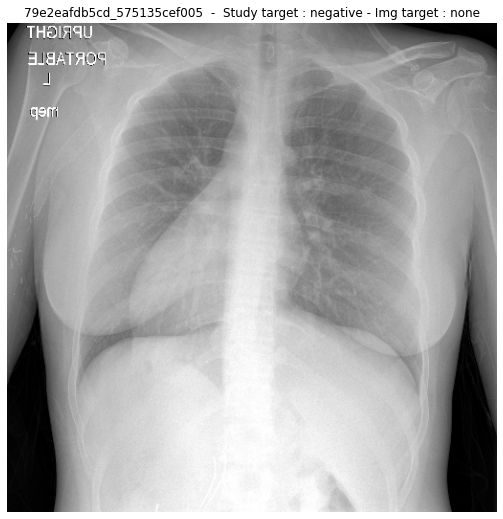

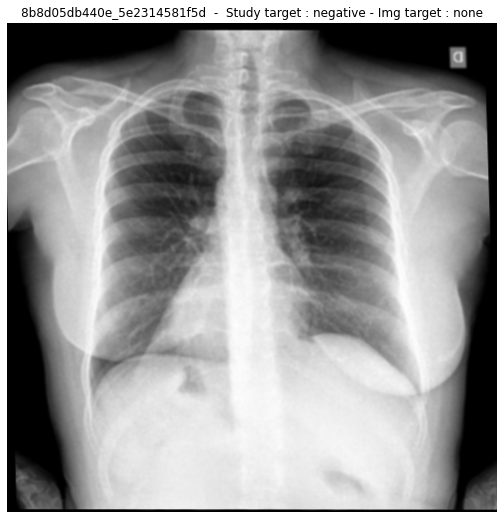

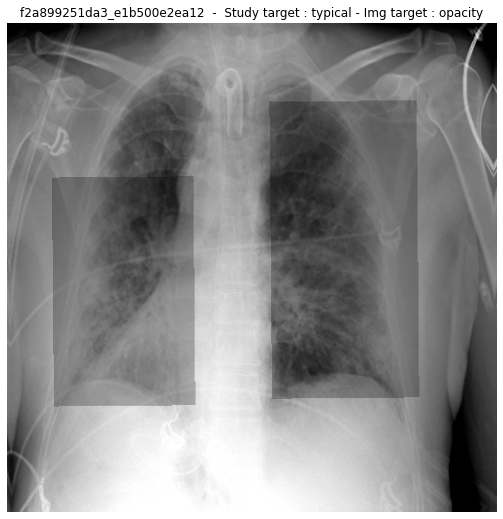

In [26]:
transforms = get_transfos_cls(augment=True)
dataset = CovidClsDataset(df, DATA_PATH + f"train_{SIZE}/", transforms=transforms)

for i in np.random.choice(len(dataset), 3):

    img, mask, y, y_img, boxes = dataset[i]
    
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy().transpose(1, 2, 0)
        mask = mask.cpu().numpy()[:, :, None].astype(int)
        
        img = (img * mask * 0.75 + img * (1 - mask)).astype(int)

    plt.figure(figsize=(9, 9))
    plot_sample(img, [], bbox_format="yolo")
    plt.title(
        f'{df["save_name"][i][:-4]}  -  Study target : {CLASSES[int(y)]} - '
        f'Img target : {CLASSES_IMG[int(y_img)]}'
    )
    plt.show()

### Training

In [ ]:
BATCH_SIZES = {
    'tf_efficientnetv2_s_in21ft1k': 8,
    'tf_efficientnetv2_m_in21ft1k': 12,
}

In [ ]:
class Config:
    """
    Parameters used for training
    """
    # General
    seed = 42
    verbose = 1

    size = SIZE
    bbox_format = "yolo"
    root_dir = DATA_PATH + f"train_{SIZE}/"
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True

    # k-fold
    k = 5
    folds_col = "kfold"
    selected_folds = [0, 1, 2, 3, 4]

    # Model
    selected_model = 'tf_efficientnetv2_m_in21ft1k'
    use_unet = False
    pretrained = False
    num_classes = len(CLASSES)

    # Training
    loss_config = {  
        "w_bce": 0.75,
        "w_seg_loss": 0.95 if "v2_s" in selected_model else 0.75,
        "seg_loss_multiplier": 4 if "v2_s" in selected_model else 2,
        "w_study": 2,
        "w_img": 1,
    }
    use_fp16 = False if "v2_s" in selected_model else True
    samples_per_patient = 1
    optimizer = ["Adam", "RAdam_lookahead", "RAdam"]
    batch_size = BATCH_SIZES[selected_model]
    epochs = [10] #, 5, 5]

    lr = [1e-3, 1e-4, 1e-5]
    warmup_prop = [0.05, 0.25, 0.5]
    val_bs = batch_size * 2

    first_epoch_eval = 0

    mix = "cutmix"
    mix_proba = 0.5
    mix_alpha = 0.4

    name = "model"

In [ ]:
DEBUG = True
log_folder = None

In [ ]:
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f'Logging results to {log_folder}')
    save_config(Config, log_folder + 'config')
    df.to_csv(log_folder + 'data.csv', index=False)
    create_logger(directory=log_folder, name="logs.txt")

pred_oof_study, pred_oof_img = k_fold(
    Config,
    df,
    df_extra=None,
    log_folder=log_folder
)